## Distribution of conflicting gradients 

In [2]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt 

/home/tanguy/miniconda/envs/env_tpp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


16


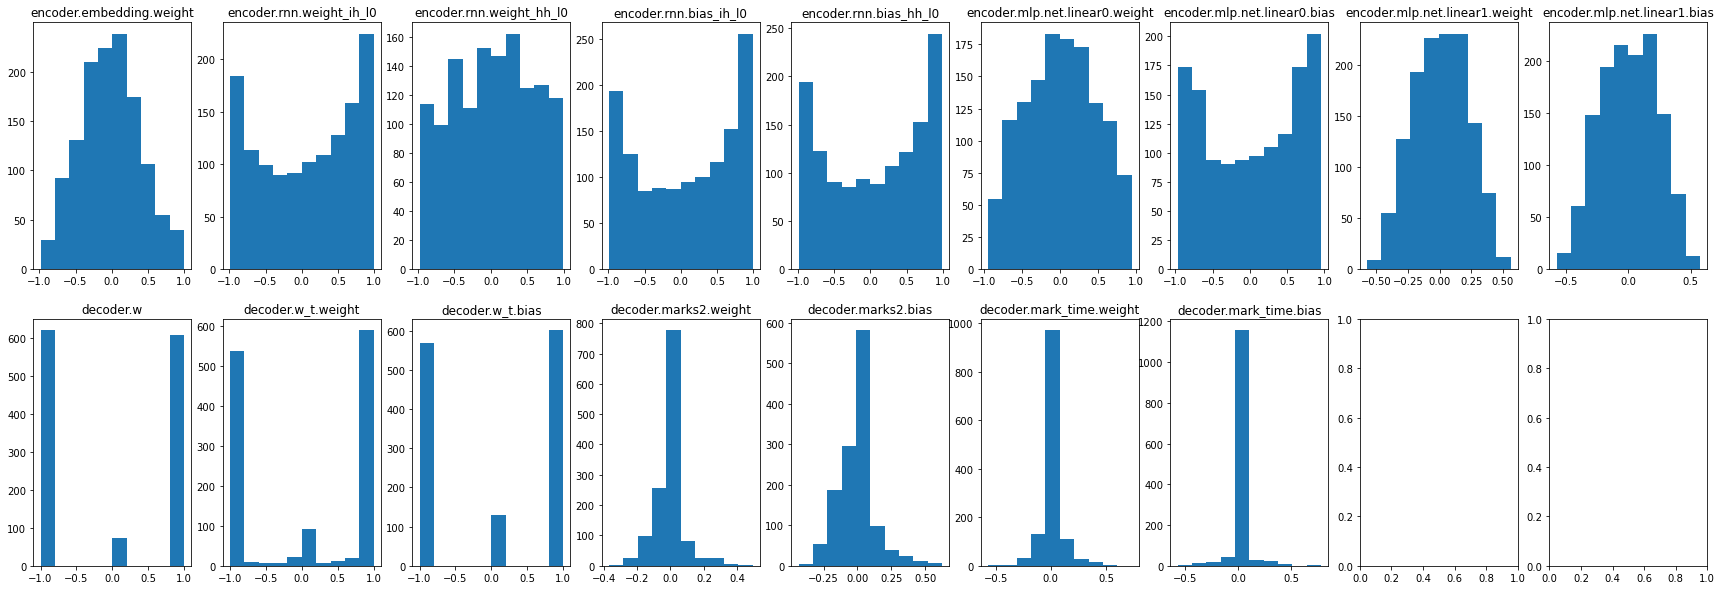

In [3]:
dataset = 'mooc_filtered'

file = 'results/neurips/lastfm_filtered/lastfm_filtered_gru_rmtpp-jd_temporal_with_labels_split0.txt'

with open(file, 'rb') as f:
    data = pickle.load(f)
cos = data['train'][-2]['dot_products']

nrows, ncols = 2, 9
print(len(cos))

fig, axes = plt.subplots(nrows, ncols, figsize=(30,10))

i = 0
for name, dot in cos.items():
    irow = int(i/ncols)
    icol = i % ncols  
    axes[irow, icol].hist(dot)
    axes[irow,icol].set_title(name)
    i += 1
plt.show()